In [1]:
DATA_PATH = r"../experiments/xor_multiple_results_20250827_061752.json"

In [14]:
import re
import json
import ast
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def analyze_perfect_solutions(filename):
    params, perfect, imperfect = load_and_categorize_results(filename)
    
    # Data structures for analysis
    all_solutions = []
    node_positions = defaultdict(list)  # position -> list of nodes
    node_frequencies = defaultdict(int)  # node type -> count
    weights_by_position = defaultdict(list)  # position -> list of weights
    biases_by_function = defaultdict(list)  # function type -> list of biases
    
    for sol in perfect:
        ind_str = sol['best_individual']['expression']
        effective = get_effective_chromosome(ind_str, params['head_length'])
        
        # Store solution data
        solution_data = {
            'perfect': True,
            'iteration': sol['iteration'],
            'generations': sol['generations'],
            'active_nodes': effective['active_expression'],
            'active_weights': effective['active_weights'],
            'active_biases': effective['active_biases'],
            'active_indices': effective['active_indices']
        }
        all_solutions.append(solution_data)
        
        # Node positions and frequencies
        for pos, node in enumerate(effective['active_expression']):
            node_positions[pos].append(node)
            node_frequencies[node] += 1
        
        # Weights by position
        for pos, weight in enumerate(effective['active_weights']):
            weights_by_position[pos].append(weight)
        
        # Biases by function type
        func_idx = 0
        for node in effective['active_expression']:
            if node in ['relu', 'tanh', 'sigmoid', 'add', 'subtract', 'multiply', 
                        'and_f', 'or_f', 'not_f', 'add3', 'relu3', 'tanh3', 'sigmoid3']:
                if func_idx < len(effective['active_biases']):
                    biases_by_function[node].append(effective['active_biases'][func_idx])
                    func_idx += 1
    
    return {
        'solutions': all_solutions,
        'node_positions': dict(node_positions),
        'node_frequencies': dict(node_frequencies),
        'weights_by_position': dict(weights_by_position),
        'biases_by_function': dict(biases_by_function)
    }

In [15]:
results = analyze_perfect_solutions(DATA_PATH)

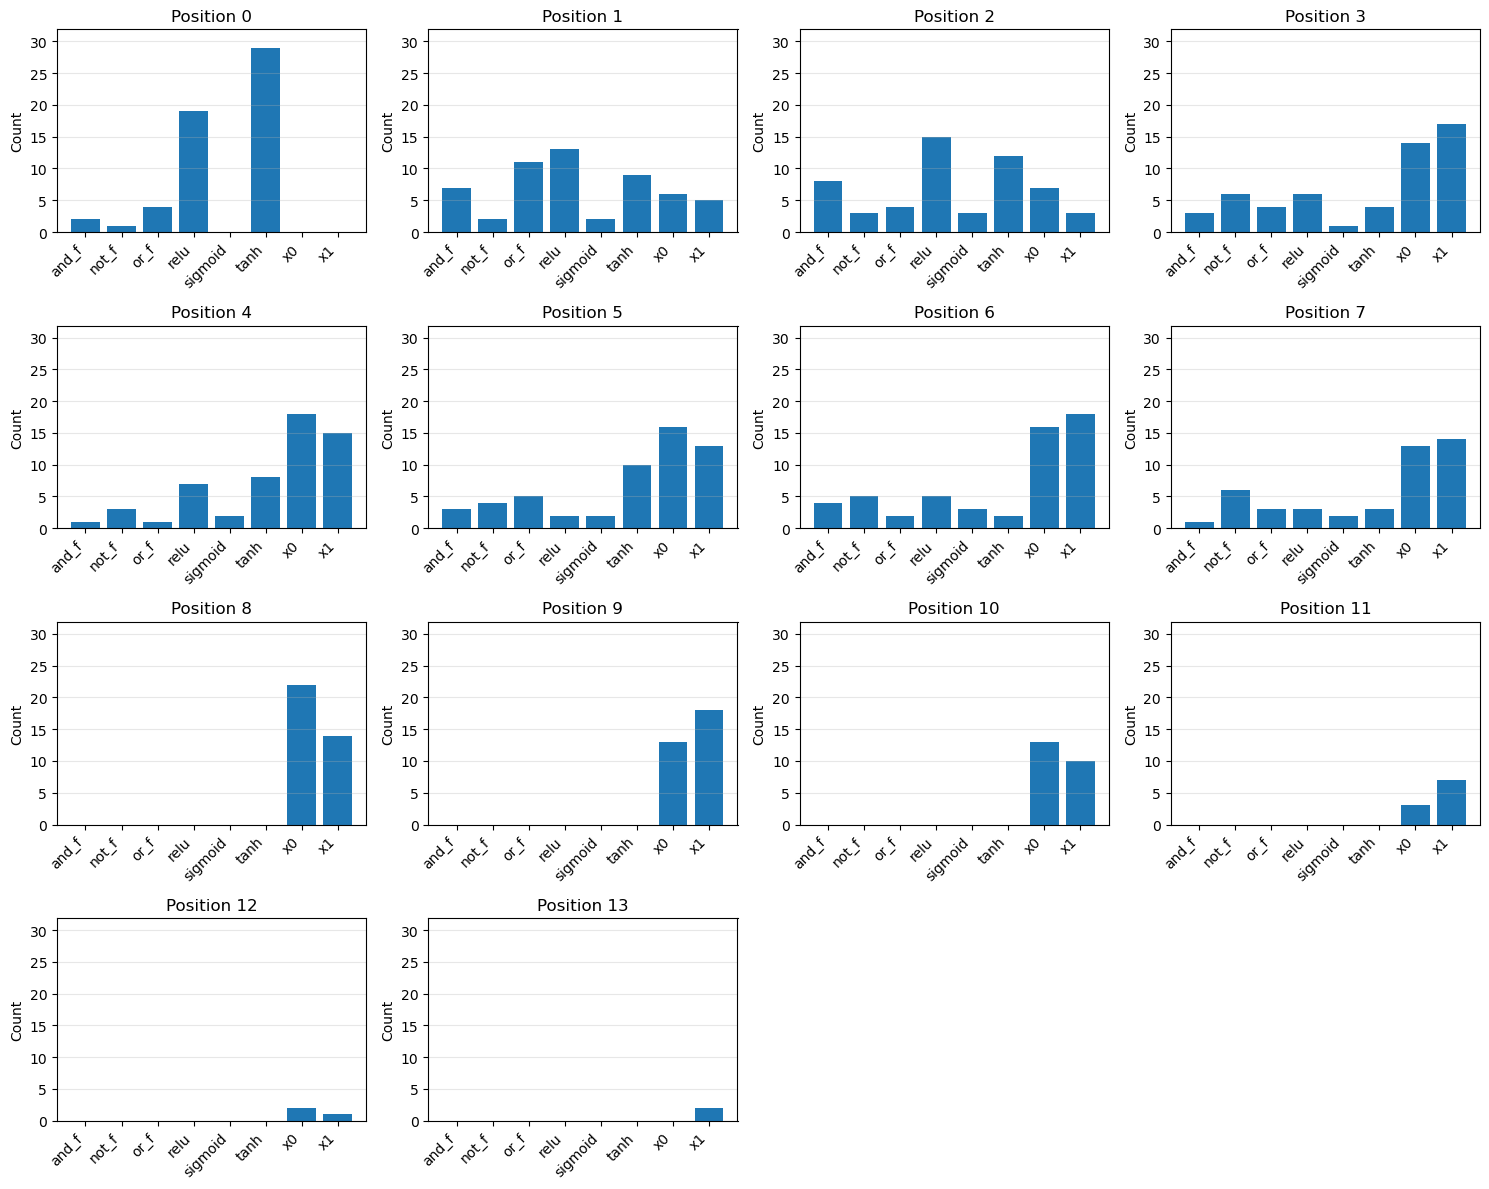

In [22]:
def plot_node_position_frequencies(results, figsize=(15, 12)):
   node_positions = results['node_positions']
   max_position = max(node_positions.keys())
   
   # Get all unique nodes across all positions
   all_nodes = set()
   for nodes in node_positions.values():
       all_nodes.update(nodes)
   all_nodes = sorted(list(all_nodes))
   
   # Calculate grid dimensions
   cols = 4  # charts per row
   rows = (max_position + 1 + cols - 1) // cols
   
   fig, axes = plt.subplots(rows, cols, figsize=figsize)
   axes = axes.flatten()
   
   # Get y-axis limit from position 0
   if 0 in node_positions:
       counter0 = Counter(node_positions[0])
       max_count = max(counter0.values()) if counter0 else 1
       ylim = (0, max_count * 1.1)  # Add 10% padding
   else:
       ylim = None
   
   for pos in range(max_position + 1):
       ax = axes[pos]
       
       if pos in node_positions:
           # Count frequencies
           counter = Counter(node_positions[pos])
           
           # Get counts for all nodes (0 if not present)
           counts = [counter.get(node, 0) for node in all_nodes]
           
           # Create bar chart
           x = np.arange(len(all_nodes))
           ax.bar(x, counts)
           ax.set_xticks(x)
           ax.set_xticklabels(all_nodes, rotation=45, ha='right')
           ax.set_ylabel('Count')
           ax.set_title(f'Position {pos}')
           ax.grid(axis='y', alpha=0.3)
           
           # Set consistent y-axis limit
           if ylim:
               ax.set_ylim(ylim)
       else:
           ax.set_visible(False)
   
   # Hide unused subplots
   for i in range(max_position + 1, len(axes)):
       axes[i].set_visible(False)
   
   plt.tight_layout()
   plt.show()
# Usage
plot_node_position_frequencies(results)